<a href="https://colab.research.google.com/github/madhav48/DigitRecognition/blob/main/DigitRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm

%matplotlib inline

In [350]:
# Mount google drive to access the  files for the training data..
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [109]:
# Load the excel file for training..

data_file = "/content/drive/MyDrive/train.csv"
df = pd.read_csv(data_file)

<h1> Data Processing </h1>

In [110]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# Get all the inputs and output rows for training..

inputs = []
outputs = []

for index, rows in df.iterrows():

  input = rows.values
  output = rows[0]
  input = input[1:]

  inputs.append(input)
  outputs.append(output)

df = pd.DataFrame({'pixels' : inputs, 'label' : outputs})
len(df)

42000

In [112]:
# Function to show image..

def show_image(image, normalized = False):

  image = np.array(image).reshape(28,28)
  plt.imshow(image, cmap = 'gray')

# def show_images()



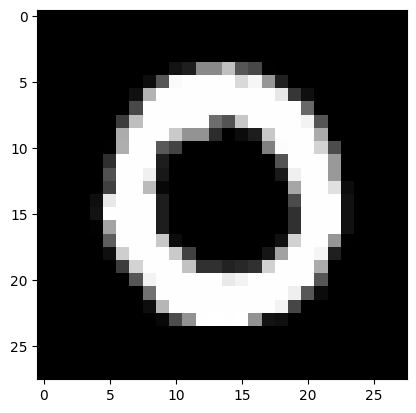

In [113]:
show_image(df['pixels'][1])

In [114]:
# Normalize image pixels.. that is convert 0-255 to 0-1...

for index, row in df.iterrows():

  pixels = list(row['pixels'])
  newpixels  = []
  for pixel in pixels:
    newpixels.append(pixel/255)
  df.at[index , 'pixels'] = newpixels


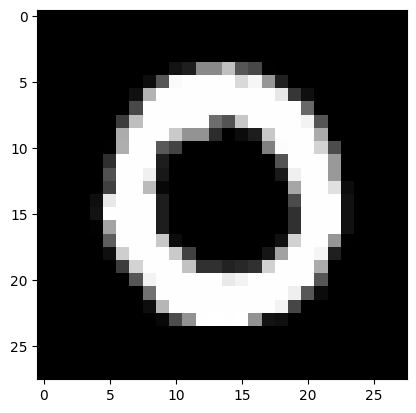

In [115]:
show_image(df['pixels'][1])

In [116]:
# Split the dataset for training and validation..
train_df , val_df = train_test_split(df, test_size = 0.2)
len(val_df)

8400

In [117]:
# Reset index..
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [118]:
train_df.head()

,index,pixels,label
0,34552,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,10792,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
2,13869,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,11453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,36639,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6


<h1> Use GPU </h1>

In [119]:
# Check for CUDA (GPU)..
torch.cuda.is_available()

True

In [120]:
device = torch.device('cuda')
device

device(type='cuda')

In [121]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

<h1>Dataloader for loading data into batches...</h1>

In [122]:
# Define a pytorch dataset class for dataset..
class MNIST(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        # Load data and get label
        X = np.array(self.df['pixels'][index]).reshape(28,28,1)
        y = torch.tensor(self.df['label'][index])

        if self.transform:
            X = self.transform(X)

        return X, y

In [123]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [124]:
# Apply transformations..
input_size = 28

# define the transformation of the train images.
train_transform = transforms.Compose([transforms.ToTensor()])

# train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
#                                       transforms.RandomVerticalFlip(),
#                                       transforms.RandomRotation(20),
#                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize(norm_mean, norm_std)])



# define the transformation of the val images.
val_transform = transforms.Compose([transforms.ToTensor()])

In [125]:
# Create dataloader...

batch_size = 128

train_set = MNIST(train_df, transform = train_transform)
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
train_loader = DeviceDataLoader(train_loader, device)

val_set = MNIST(val_df, transform = val_transform)
val_loader = DataLoader(val_set, batch_size*2, num_workers=4, pin_memory=True)
val_loader = DeviceDataLoader(val_loader, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 1, 28, 28])


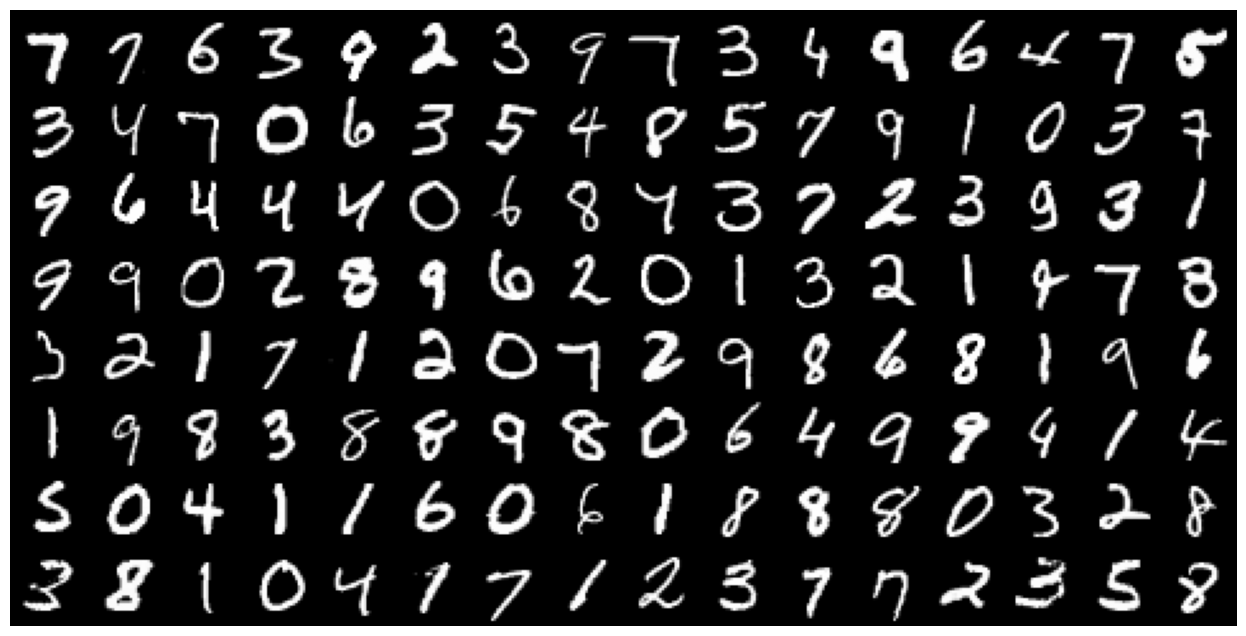

In [126]:
# Plot images from one batch...

for images, _ in train_loader:

    if torch.cuda.is_available():
      images = images.cpu()



    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    # print(_)
    break

<h1>Define Model</h1>

In [127]:
# Accuracy function..
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [163]:
# Model class...

class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()

        # Convolutional layers..
        self.conv_layer = nn.Sequential(

                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # in_channels=1
                nn.Conv2d(in_channels = 1, out_channels = 12, kernel_size = 3, padding = 1, stride = 1),
                nn.ReLU(),

                # [(28 + 2*1 - 3)/1] + 1 = 28.
                nn.MaxPool2d(kernel_size=2),
                # 28 / 2 = 14

                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),

                # [(14 + 2*1 - 3)/1] + 1 = 14.
                nn.MaxPool2d(kernel_size=2)
                # 14 / 2 = 7
        )

        # Linear layers...
        self.linear_layers = nn.Sequential(

                # output_channel=24 and size - 7*7
                nn.Linear(in_features=24*7*7, out_features=64),
                nn.ReLU(),
                nn.Dropout(p=0.2), #  to avoid overfitting
                nn.Linear(in_features=64, out_features=10)
        )


    def forward(self, x):

        x = x.float()

        # Apply convolutional layers for future extraction..
        x = self.conv_layer(x)

        # Rearrange the output into a vector -> flatten
        x = x.view(x.size(0), -1)

        # Apply linear layers for classification..
        x = self.linear_layers(x)

        # Apply softmax layer for getting probabilites..
        x = F.log_softmax(x, dim=1)
        return x

In [164]:
def train_model(train_loader, model, criterion, optimizer, epoch):

    model.train()

    for i, data in enumerate(train_loader):

        images, labels = data

        optimizer.zero_grad()
        outputs = model(images)

        # Gradient Descent..
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_acc =  accuracy(outputs,labels)

        if (i + 1) % 25 == 0:
            print(f"Epoch : {epoch}, iter: {i+1}/{len(train_loader)}, train loss: {loss}, train acc: {train_acc}")
    return

In [165]:
def validate_model(val_loader, model, criterion, optimizer, epoch):

    model.eval()

    acc_sum = 0
    loss_sum = 0
    iter  = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):

            images, labels = data

            outputs = model(images)
            acc = accuracy(outputs,labels)
            loss = criterion(outputs, labels).item()
            iter += 1

            acc_sum += acc
            loss_sum += loss

    print('------------------------------------------------------------')
    print(f"Epoch: {epoch}, val_loss: {loss_sum/iter}, val_acc: {acc_sum/iter}")
    print('------------------------------------------------------------')
    return loss_sum/iter , acc_sum/iter

In [291]:
model = MnistModel()
model = to_device(model,device)

In [281]:
model

MnistModel(
  (conv_layer): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [282]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, criterion = F.cross_entropy):

    history == []
    optimizer = opt_func(model.parameters(), lr)

    best_val_acc = 0

    for epoch in tqdm(range(1,epochs+1)):

        # Training Phase...
        train_model(train_loader, model, criterion, optimizer, epoch)

        # Validation phase...
        val_loss , val_acc = validate_model(val_loader, model, criterion, optimizer, epoch)

        history.append((val_loss,val_acc))

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print('*****************************************************')
            print(f"Best Record: Val Loss: {val_loss}, Val Acc: {val_acc}")
            print('*****************************************************')
    return history

In [283]:
history = []

In [301]:
history += fit(20, 0.5, model, train_loader, val_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 1, iter: 25/263, train loss: 1.9770585298538208, train acc: 0.3203125
Epoch : 1, iter: 50/263, train loss: 1.6931345462799072, train acc: 0.4375
Epoch : 1, iter: 75/263, train loss: 0.5605038404464722, train acc: 0.8515625
Epoch : 1, iter: 100/263, train loss: 0.4637393057346344, train acc: 0.859375
Epoch : 1, iter: 125/263, train loss: 0.461052268743515, train acc: 0.84375
Epoch : 1, iter: 150/263, train loss: 0.37195712327957153, train acc: 0.875
Epoch : 1, iter: 175/263, train loss: 0.46380317211151123, train acc: 0.8515625
Epoch : 1, iter: 200/263, train loss: 0.13477197289466858, train acc: 0.96875
Epoch : 1, iter: 225/263, train loss: 0.20948480069637299, train acc: 0.9375
Epoch : 1, iter: 250/263, train loss: 0.20551687479019165, train acc: 0.9375



0it [00:00, ?it/s]
1it [00:00,  2.82it/s]
4it [00:00,  9.50it/s]
12it [00:00, 27.80it/s]
17it [00:00, 29.72it/s]
23it [00:00, 34.83it/s]
33it [00:01, 25.55it/s]
  5%|▌         | 1/20 [00:06<01:55,  6.05s/it]

------------------------------------------------------------
Epoch: 1, val_loss: 0.143273072486574, val_acc: 0.9566124081611633
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.143273072486574, Val Acc: 0.9566124081611633
*****************************************************
Epoch : 2, iter: 25/263, train loss: 0.20538803935050964, train acc: 0.953125
Epoch : 2, iter: 50/263, train loss: 0.18104390799999237, train acc: 0.96875
Epoch : 2, iter: 75/263, train loss: 0.0638711228966713, train acc: 0.9921875
Epoch : 2, iter: 100/263, train loss: 0.17899659276008606, train acc: 0.9609375
Epoch : 2, iter: 125/263, train loss: 0.15681129693984985, train acc: 0.96875
Epoch : 2, iter: 150/263, train loss: 0.085839182138443, train acc: 0.984375
Epoch : 2, iter: 175/263, train loss: 0.07974274456501007, train acc: 0.9765625
Epoch : 2, iter: 200/263, train loss: 0.06269706040620804, train acc: 0.9765625
Epoch


0it [00:00, ?it/s]
1it [00:00,  2.30it/s]
5it [00:00, 10.89it/s]
8it [00:00, 15.28it/s]
11it [00:00, 19.06it/s]
14it [00:00, 18.33it/s]
18it [00:01, 20.16it/s]
21it [00:01, 22.04it/s]
24it [00:01, 21.85it/s]
33it [00:01, 17.40it/s]
 10%|█         | 2/20 [00:12<01:49,  6.08s/it]

------------------------------------------------------------
Epoch: 2, val_loss: 0.07866907988985379, val_acc: 0.9749781489372253
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.07866907988985379, Val Acc: 0.9749781489372253
*****************************************************
Epoch : 3, iter: 25/263, train loss: 0.07139671593904495, train acc: 0.984375
Epoch : 3, iter: 50/263, train loss: 0.07762095332145691, train acc: 0.96875
Epoch : 3, iter: 75/263, train loss: 0.12616349756717682, train acc: 0.9609375
Epoch : 3, iter: 100/263, train loss: 0.10525892674922943, train acc: 0.96875
Epoch : 3, iter: 125/263, train loss: 0.09231974929571152, train acc: 0.9609375
Epoch : 3, iter: 150/263, train loss: 0.16057078540325165, train acc: 0.9609375
Epoch : 3, iter: 175/263, train loss: 0.06559664756059647, train acc: 0.984375
Epoch : 3, iter: 200/263, train loss: 0.11674489080905914, train acc: 0.945312


0it [00:00, ?it/s]
1it [00:00,  1.86it/s]
4it [00:00,  6.85it/s]
8it [00:00, 13.68it/s]
11it [00:00, 16.65it/s]
14it [00:01, 18.89it/s]
17it [00:01, 20.19it/s]
20it [00:01, 21.35it/s]
23it [00:01, 22.30it/s]
26it [00:01, 22.97it/s]
33it [00:01, 16.60it/s]
 15%|█▌        | 3/20 [00:19<01:55,  6.81s/it]

------------------------------------------------------------
Epoch: 3, val_loss: 0.11096756408611934, val_acc: 0.9629953503608704
------------------------------------------------------------
Epoch : 4, iter: 25/263, train loss: 0.02845482900738716, train acc: 0.9921875
Epoch : 4, iter: 50/263, train loss: 0.12168727070093155, train acc: 0.96875
Epoch : 4, iter: 75/263, train loss: 0.08897367119789124, train acc: 0.9609375
Epoch : 4, iter: 100/263, train loss: 0.16683277487754822, train acc: 0.9609375
Epoch : 4, iter: 125/263, train loss: 0.04323992133140564, train acc: 0.9921875
Epoch : 4, iter: 150/263, train loss: 0.056204184889793396, train acc: 0.984375
Epoch : 4, iter: 175/263, train loss: 0.05184401199221611, train acc: 0.984375
Epoch : 4, iter: 200/263, train loss: 0.0634709969162941, train acc: 0.9765625
Epoch : 4, iter: 225/263, train loss: 0.10247062146663666, train acc: 0.9453125
Epoch : 4, iter: 250/263, train loss: 0.03262617066502571, train acc: 0.9921875



0it [00:00, ?it/s]
1it [00:00,  2.05it/s]
2it [00:00,  3.60it/s]
6it [00:00, 11.37it/s]
10it [00:00, 15.81it/s]
14it [00:01, 18.21it/s]
18it [00:01, 19.63it/s]
22it [00:01, 20.42it/s]
26it [00:01, 21.76it/s]
33it [00:02, 16.20it/s]
 20%|██        | 4/20 [00:26<01:46,  6.68s/it]

------------------------------------------------------------
Epoch: 4, val_loss: 0.06304067285787879, val_acc: 0.9808329939842224
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.06304067285787879, Val Acc: 0.9808329939842224
*****************************************************
Epoch : 5, iter: 25/263, train loss: 0.05179845169186592, train acc: 0.9765625
Epoch : 5, iter: 50/263, train loss: 0.04556375369429588, train acc: 0.9765625
Epoch : 5, iter: 75/263, train loss: 0.08038922399282455, train acc: 0.96875
Epoch : 5, iter: 100/263, train loss: 0.0467645637691021, train acc: 0.984375
Epoch : 5, iter: 125/263, train loss: 0.13393861055374146, train acc: 0.953125
Epoch : 5, iter: 150/263, train loss: 0.0767318606376648, train acc: 0.96875
Epoch : 5, iter: 175/263, train loss: 0.08035468310117722, train acc: 0.96875
Epoch : 5, iter: 200/263, train loss: 0.09097723662853241, train acc: 0.953125
Epo


0it [00:00, ?it/s]
1it [00:00,  2.86it/s]
7it [00:00, 18.85it/s]
11it [00:00, 24.08it/s]
16it [00:00, 31.19it/s]
20it [00:00, 33.35it/s]
24it [00:00, 33.95it/s]
33it [00:01, 25.63it/s]
 25%|██▌       | 5/20 [00:32<01:37,  6.48s/it]

------------------------------------------------------------
Epoch: 5, val_loss: 0.064608970656991, val_acc: 0.9803321361541748
------------------------------------------------------------
Epoch : 6, iter: 25/263, train loss: 0.1331189125776291, train acc: 0.9609375
Epoch : 6, iter: 50/263, train loss: 0.03530284762382507, train acc: 0.984375
Epoch : 6, iter: 75/263, train loss: 0.05519164726138115, train acc: 0.9765625
Epoch : 6, iter: 100/263, train loss: 0.03169183433055878, train acc: 0.9921875
Epoch : 6, iter: 125/263, train loss: 0.026739051565527916, train acc: 0.9921875
Epoch : 6, iter: 150/263, train loss: 0.049513526260852814, train acc: 0.984375
Epoch : 6, iter: 175/263, train loss: 0.16997592151165009, train acc: 0.953125
Epoch : 6, iter: 200/263, train loss: 0.05553821101784706, train acc: 0.984375
Epoch : 6, iter: 225/263, train loss: 0.07394756376743317, train acc: 0.96875
Epoch : 6, iter: 250/263, train loss: 0.08859633654356003, train acc: 0.9609375



0it [00:00, ?it/s]
1it [00:00,  2.92it/s]
6it [00:00, 15.82it/s]
11it [00:00, 22.74it/s]
14it [00:00, 23.54it/s]
19it [00:00, 29.37it/s]
23it [00:00, 31.91it/s]
27it [00:01, 33.76it/s]
33it [00:01, 23.20it/s]
 30%|███       | 6/20 [00:38<01:27,  6.23s/it]

------------------------------------------------------------
Epoch: 6, val_loss: 0.05153571059362906, val_acc: 0.984001636505127
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.05153571059362906, Val Acc: 0.984001636505127
*****************************************************
Epoch : 7, iter: 25/263, train loss: 0.03168013319373131, train acc: 0.9921875
Epoch : 7, iter: 50/263, train loss: 0.012360991910099983, train acc: 1.0
Epoch : 7, iter: 75/263, train loss: 0.02825176902115345, train acc: 0.984375
Epoch : 7, iter: 100/263, train loss: 0.044991787523031235, train acc: 0.984375
Epoch : 7, iter: 125/263, train loss: 0.027994683012366295, train acc: 0.9921875
Epoch : 7, iter: 150/263, train loss: 0.09694890677928925, train acc: 0.96875
Epoch : 7, iter: 175/263, train loss: 0.012907230295240879, train acc: 1.0
Epoch : 7, iter: 200/263, train loss: 0.03650033101439476, train acc: 0.9921875
Epoch 


0it [00:00, ?it/s]
1it [00:00,  3.61it/s]
2it [00:00,  5.40it/s]
6it [00:00, 14.52it/s]
11it [00:00, 24.24it/s]
14it [00:00, 22.80it/s]
22it [00:00, 35.71it/s]
26it [00:01, 36.70it/s]
33it [00:01, 25.36it/s]
 35%|███▌      | 7/20 [00:44<01:23,  6.41s/it]

------------------------------------------------------------
Epoch: 7, val_loss: 0.059845556589690124, val_acc: 0.9841200113296509
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.059845556589690124, Val Acc: 0.9841200113296509
*****************************************************
Epoch : 8, iter: 25/263, train loss: 0.03525278717279434, train acc: 0.984375
Epoch : 8, iter: 50/263, train loss: 0.05076434835791588, train acc: 0.984375
Epoch : 8, iter: 75/263, train loss: 0.0894695445895195, train acc: 0.96875
Epoch : 8, iter: 100/263, train loss: 0.0057440525852143764, train acc: 1.0
Epoch : 8, iter: 125/263, train loss: 0.03192787989974022, train acc: 0.984375
Epoch : 8, iter: 150/263, train loss: 0.05911124870181084, train acc: 0.9765625
Epoch : 8, iter: 175/263, train loss: 0.03995058685541153, train acc: 0.9921875
Epoch : 8, iter: 200/263, train loss: 0.026170168071985245, train acc: 0.9921875


0it [00:00, ?it/s]
1it [00:00,  3.57it/s]
2it [00:00,  5.26it/s]
8it [00:00, 18.79it/s]
12it [00:00, 21.04it/s]
20it [00:00, 28.93it/s]
33it [00:01, 25.72it/s]
 40%|████      | 8/20 [00:50<01:13,  6.14s/it]

------------------------------------------------------------
Epoch: 8, val_loss: 0.05773763590012536, val_acc: 0.9809877872467041
------------------------------------------------------------
Epoch : 9, iter: 25/263, train loss: 0.04618558660149574, train acc: 0.984375
Epoch : 9, iter: 50/263, train loss: 0.02009621262550354, train acc: 0.9921875
Epoch : 9, iter: 75/263, train loss: 0.010422364808619022, train acc: 1.0
Epoch : 9, iter: 100/263, train loss: 0.16403628885746002, train acc: 0.96875
Epoch : 9, iter: 125/263, train loss: 0.04497520625591278, train acc: 0.9765625
Epoch : 9, iter: 150/263, train loss: 0.008285590447485447, train acc: 1.0
Epoch : 9, iter: 175/263, train loss: 0.016708558425307274, train acc: 1.0
Epoch : 9, iter: 200/263, train loss: 0.11056775599718094, train acc: 0.9609375
Epoch : 9, iter: 225/263, train loss: 0.01771705597639084, train acc: 0.9921875
Epoch : 9, iter: 250/263, train loss: 0.04041286185383797, train acc: 0.9765625



0it [00:00, ?it/s]
1it [00:00,  2.83it/s]
6it [00:00, 16.20it/s]
10it [00:00, 22.91it/s]
15it [00:00, 30.67it/s]
20it [00:00, 34.69it/s]
25it [00:00, 36.07it/s]
33it [00:01, 26.07it/s]
 45%|████▌     | 9/20 [00:57<01:10,  6.40s/it]

------------------------------------------------------------
Epoch: 9, val_loss: 0.04708725767153682, val_acc: 0.985950231552124
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.04708725767153682, Val Acc: 0.985950231552124
*****************************************************
Epoch : 10, iter: 25/263, train loss: 0.019106589257717133, train acc: 0.9921875
Epoch : 10, iter: 50/263, train loss: 0.035200085490942, train acc: 0.9921875
Epoch : 10, iter: 75/263, train loss: 0.007383689284324646, train acc: 1.0
Epoch : 10, iter: 100/263, train loss: 0.0182159636169672, train acc: 1.0
Epoch : 10, iter: 125/263, train loss: 0.03473099693655968, train acc: 0.984375
Epoch : 10, iter: 150/263, train loss: 0.0470145158469677, train acc: 0.9765625
Epoch : 10, iter: 175/263, train loss: 0.0076732630841434, train acc: 1.0
Epoch : 10, iter: 200/263, train loss: 0.07304538786411285, train acc: 0.9765625
Epoch : 


0it [00:00, ?it/s]
1it [00:00,  2.80it/s]
6it [00:00, 15.97it/s]
10it [00:00, 20.10it/s]
14it [00:00, 24.21it/s]
18it [00:00, 27.80it/s]
23it [00:00, 33.72it/s]
33it [00:01, 25.56it/s]
 50%|█████     | 10/20 [01:03<01:01,  6.14s/it]

------------------------------------------------------------
Epoch: 10, val_loss: 0.05759677214717323, val_acc: 0.9847665429115295
------------------------------------------------------------
Epoch : 11, iter: 25/263, train loss: 0.06811556220054626, train acc: 0.96875
Epoch : 11, iter: 50/263, train loss: 0.017519909888505936, train acc: 1.0
Epoch : 11, iter: 75/263, train loss: 0.008662995882332325, train acc: 1.0
Epoch : 11, iter: 100/263, train loss: 0.07628249377012253, train acc: 0.96875
Epoch : 11, iter: 125/263, train loss: 0.14133287966251373, train acc: 0.9765625
Epoch : 11, iter: 150/263, train loss: 0.03206109255552292, train acc: 0.984375
Epoch : 11, iter: 175/263, train loss: 0.03905687853693962, train acc: 0.9765625
Epoch : 11, iter: 200/263, train loss: 0.017539458349347115, train acc: 0.9921875
Epoch : 11, iter: 225/263, train loss: 0.025726139545440674, train acc: 0.9921875
Epoch : 11, iter: 250/263, train loss: 0.05283469334244728, train acc: 0.96875



0it [00:00, ?it/s]
1it [00:00,  1.75it/s]
4it [00:00,  7.06it/s]
8it [00:00, 13.50it/s]
11it [00:00, 16.23it/s]
17it [00:01, 23.18it/s]
22it [00:01, 29.07it/s]
26it [00:01, 31.38it/s]
33it [00:01, 20.56it/s]
 55%|█████▌    | 11/20 [01:09<00:57,  6.37s/it]

------------------------------------------------------------
Epoch: 11, val_loss: 0.05698344579926043, val_acc: 0.9830820560455322
------------------------------------------------------------
Epoch : 12, iter: 25/263, train loss: 0.010841753333806992, train acc: 0.9921875
Epoch : 12, iter: 50/263, train loss: 0.029547281563282013, train acc: 0.9921875
Epoch : 12, iter: 75/263, train loss: 0.02134130336344242, train acc: 1.0
Epoch : 12, iter: 100/263, train loss: 0.06501173228025436, train acc: 0.984375
Epoch : 12, iter: 125/263, train loss: 0.00895863026380539, train acc: 1.0
Epoch : 12, iter: 150/263, train loss: 0.009212777018547058, train acc: 1.0
Epoch : 12, iter: 175/263, train loss: 0.006055829580873251, train acc: 1.0
Epoch : 12, iter: 200/263, train loss: 0.037609685212373734, train acc: 0.984375
Epoch : 12, iter: 225/263, train loss: 0.05882222205400467, train acc: 0.984375
Epoch : 12, iter: 250/263, train loss: 0.047030769288539886, train acc: 0.984375



0it [00:00, ?it/s]
1it [00:00,  2.58it/s]
9it [00:00, 20.02it/s]
13it [00:00, 23.66it/s]
17it [00:00, 25.52it/s]
21it [00:00, 28.19it/s]
25it [00:01, 30.61it/s]
33it [00:01, 24.56it/s]
 60%|██████    | 12/20 [01:15<00:49,  6.14s/it]

------------------------------------------------------------
Epoch: 12, val_loss: 0.056403108166925835, val_acc: 0.9850943684577942
------------------------------------------------------------
Epoch : 13, iter: 25/263, train loss: 0.05864676088094711, train acc: 0.984375
Epoch : 13, iter: 50/263, train loss: 0.02973206900060177, train acc: 0.9921875
Epoch : 13, iter: 75/263, train loss: 0.007233709562569857, train acc: 1.0
Epoch : 13, iter: 100/263, train loss: 0.009039759635925293, train acc: 1.0
Epoch : 13, iter: 125/263, train loss: 0.07478972524404526, train acc: 0.9765625
Epoch : 13, iter: 150/263, train loss: 0.041364651173353195, train acc: 0.9921875
Epoch : 13, iter: 175/263, train loss: 0.00846601091325283, train acc: 1.0
Epoch : 13, iter: 200/263, train loss: 0.05093242973089218, train acc: 0.9765625
Epoch : 13, iter: 225/263, train loss: 0.05044073984026909, train acc: 0.9765625
Epoch : 13, iter: 250/263, train loss: 0.01690603233873844, train acc: 1.0



0it [00:00, ?it/s]
1it [00:00,  1.68it/s]
4it [00:00,  7.06it/s]
8it [00:00, 12.36it/s]
12it [00:00, 17.70it/s]
15it [00:01, 20.27it/s]
18it [00:01, 19.23it/s]
21it [00:01, 17.90it/s]
26it [00:01, 24.44it/s]
33it [00:01, 16.74it/s]
 65%|██████▌   | 13/20 [01:22<00:44,  6.33s/it]

------------------------------------------------------------
Epoch: 13, val_loss: 0.05211095724988616, val_acc: 0.9861596822738647
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.05211095724988616, Val Acc: 0.9861596822738647
*****************************************************
Epoch : 14, iter: 25/263, train loss: 0.051797155290842056, train acc: 0.9921875
Epoch : 14, iter: 50/263, train loss: 0.011878487654030323, train acc: 1.0
Epoch : 14, iter: 75/263, train loss: 0.03600103035569191, train acc: 0.9921875
Epoch : 14, iter: 100/263, train loss: 0.0890684723854065, train acc: 0.96875
Epoch : 14, iter: 125/263, train loss: 0.04959454759955406, train acc: 0.984375
Epoch : 14, iter: 150/263, train loss: 0.01761750318109989, train acc: 1.0
Epoch : 14, iter: 175/263, train loss: 0.019596386700868607, train acc: 0.984375
Epoch : 14, iter: 200/263, train loss: 0.027428844943642616, train acc: 0.9843


0it [00:00, ?it/s]
1it [00:00,  3.60it/s]
2it [00:00,  5.52it/s]
8it [00:00, 20.21it/s]
12it [00:00, 20.86it/s]
21it [00:00, 32.74it/s]
33it [00:01, 26.40it/s]
 70%|███████   | 14/20 [01:28<00:37,  6.18s/it]

------------------------------------------------------------
Epoch: 14, val_loss: 0.060568763789805496, val_acc: 0.9842657446861267
------------------------------------------------------------
Epoch : 15, iter: 25/263, train loss: 0.025548987090587616, train acc: 0.984375
Epoch : 15, iter: 50/263, train loss: 0.01575610600411892, train acc: 0.9921875
Epoch : 15, iter: 75/263, train loss: 0.007033862639218569, train acc: 1.0
Epoch : 15, iter: 100/263, train loss: 0.021983852609992027, train acc: 0.9921875
Epoch : 15, iter: 125/263, train loss: 0.0038056480698287487, train acc: 1.0
Epoch : 15, iter: 150/263, train loss: 0.0027928513009101152, train acc: 1.0
Epoch : 15, iter: 175/263, train loss: 0.008613438345491886, train acc: 1.0
Epoch : 15, iter: 200/263, train loss: 0.029232904314994812, train acc: 0.9921875
Epoch : 15, iter: 225/263, train loss: 0.008569717407226562, train acc: 0.9921875
Epoch : 15, iter: 250/263, train loss: 0.009613356553018093, train acc: 1.0



0it [00:00, ?it/s]
1it [00:00,  2.43it/s]
9it [00:00, 19.00it/s]
13it [00:00, 21.02it/s]
17it [00:00, 21.24it/s]
21it [00:01, 22.44it/s]
25it [00:01, 23.55it/s]
33it [00:01, 19.90it/s]
 75%|███████▌  | 15/20 [01:34<00:30,  6.09s/it]

------------------------------------------------------------
Epoch: 15, val_loss: 0.05183584204254051, val_acc: 0.9873706698417664
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.05183584204254051, Val Acc: 0.9873706698417664
*****************************************************
Epoch : 16, iter: 25/263, train loss: 0.003643110627308488, train acc: 1.0
Epoch : 16, iter: 50/263, train loss: 0.007304590195417404, train acc: 1.0
Epoch : 16, iter: 75/263, train loss: 0.059787627309560776, train acc: 0.984375
Epoch : 16, iter: 100/263, train loss: 0.034139830619096756, train acc: 0.984375
Epoch : 16, iter: 125/263, train loss: 0.13790422677993774, train acc: 0.96875
Epoch : 16, iter: 150/263, train loss: 0.024096349254250526, train acc: 0.9921875
Epoch : 16, iter: 175/263, train loss: 0.026310278102755547, train acc: 0.984375
Epoch : 16, iter: 200/263, train loss: 0.0077909743413329124, train acc: 1.


0it [00:00, ?it/s]
1it [00:00,  3.05it/s]
5it [00:00, 12.08it/s]
12it [00:00, 27.19it/s]
16it [00:00, 28.27it/s]
20it [00:00, 26.30it/s]
24it [00:01, 28.48it/s]
33it [00:01, 25.43it/s]
 80%|████████  | 16/20 [01:40<00:24,  6.21s/it]

------------------------------------------------------------
Epoch: 16, val_loss: 0.05518196463923563, val_acc: 0.9857134819030762
------------------------------------------------------------
Epoch : 17, iter: 25/263, train loss: 0.016873491927981377, train acc: 0.9921875
Epoch : 17, iter: 50/263, train loss: 0.0011832963209599257, train acc: 1.0
Epoch : 17, iter: 75/263, train loss: 0.02074803225696087, train acc: 0.9921875
Epoch : 17, iter: 100/263, train loss: 0.00652617821469903, train acc: 1.0
Epoch : 17, iter: 125/263, train loss: 0.01789901591837406, train acc: 0.9921875
Epoch : 17, iter: 150/263, train loss: 0.01618683710694313, train acc: 0.9921875
Epoch : 17, iter: 175/263, train loss: 0.11052156984806061, train acc: 0.9765625
Epoch : 17, iter: 200/263, train loss: 0.004387714900076389, train acc: 1.0
Epoch : 17, iter: 225/263, train loss: 0.030986759811639786, train acc: 0.9765625
Epoch : 17, iter: 250/263, train loss: 0.05043831095099449, train acc: 0.984375



0it [00:00, ?it/s]
1it [00:00,  2.82it/s]
7it [00:00, 18.12it/s]
11it [00:00, 23.06it/s]
15it [00:00, 24.82it/s]
20it [00:00, 30.58it/s]
25it [00:00, 33.73it/s]
33it [00:01, 26.04it/s]
 85%|████████▌ | 17/20 [01:46<00:17,  6.00s/it]

------------------------------------------------------------
Epoch: 17, val_loss: 0.04750300118361007, val_acc: 0.9881719946861267
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.04750300118361007, Val Acc: 0.9881719946861267
*****************************************************
Epoch : 18, iter: 25/263, train loss: 0.019968001171946526, train acc: 0.9921875
Epoch : 18, iter: 50/263, train loss: 0.04360712692141533, train acc: 0.9921875
Epoch : 18, iter: 75/263, train loss: 0.013228824362158775, train acc: 0.9921875
Epoch : 18, iter: 100/263, train loss: 0.040852539241313934, train acc: 0.9765625
Epoch : 18, iter: 125/263, train loss: 0.028126727789640427, train acc: 0.984375
Epoch : 18, iter: 150/263, train loss: 0.014688345603644848, train acc: 0.9921875
Epoch : 18, iter: 175/263, train loss: 0.052113573998212814, train acc: 0.9765625
Epoch : 18, iter: 200/263, train loss: 0.013783219270408154


0it [00:00, ?it/s]
1it [00:00,  2.76it/s]
7it [00:00, 18.94it/s]
11it [00:00, 24.59it/s]
15it [00:00, 25.17it/s]
19it [00:00, 26.60it/s]
33it [00:01, 26.06it/s]
 90%|█████████ | 18/20 [01:53<00:12,  6.31s/it]

------------------------------------------------------------
Epoch: 18, val_loss: 0.05304468567059799, val_acc: 0.9864237308502197
------------------------------------------------------------
Epoch : 19, iter: 25/263, train loss: 0.00565737672150135, train acc: 1.0
Epoch : 19, iter: 50/263, train loss: 0.027845870703458786, train acc: 0.984375
Epoch : 19, iter: 75/263, train loss: 0.042671605944633484, train acc: 0.984375
Epoch : 19, iter: 100/263, train loss: 0.03558278828859329, train acc: 0.9765625
Epoch : 19, iter: 125/263, train loss: 0.011500619351863861, train acc: 0.9921875
Epoch : 19, iter: 150/263, train loss: 0.0026781857013702393, train acc: 1.0
Epoch : 19, iter: 175/263, train loss: 0.06820855289697647, train acc: 0.984375
Epoch : 19, iter: 200/263, train loss: 0.0034854563418775797, train acc: 1.0
Epoch : 19, iter: 225/263, train loss: 0.008426197804510593, train acc: 0.9921875
Epoch : 19, iter: 250/263, train loss: 0.050655242055654526, train acc: 0.9921875



0it [00:00, ?it/s]
1it [00:00,  3.02it/s]
5it [00:00, 14.11it/s]
9it [00:00, 20.51it/s]
12it [00:00, 23.05it/s]
18it [00:00, 31.73it/s]
23it [00:00, 34.97it/s]
33it [00:01, 26.25it/s]
 95%|█████████▌| 19/20 [01:58<00:06,  6.09s/it]

------------------------------------------------------------
Epoch: 19, val_loss: 0.05522378511501081, val_acc: 0.985804557800293
------------------------------------------------------------
Epoch : 20, iter: 25/263, train loss: 0.009402485564351082, train acc: 1.0
Epoch : 20, iter: 50/263, train loss: 0.05945313721895218, train acc: 0.9921875
Epoch : 20, iter: 75/263, train loss: 0.012560511939227581, train acc: 0.9921875
Epoch : 20, iter: 100/263, train loss: 0.0007179413223639131, train acc: 1.0
Epoch : 20, iter: 125/263, train loss: 0.02512964978814125, train acc: 0.9921875
Epoch : 20, iter: 150/263, train loss: 0.02238500863313675, train acc: 0.9921875
Epoch : 20, iter: 175/263, train loss: 0.11704453080892563, train acc: 0.9765625
Epoch : 20, iter: 200/263, train loss: 0.00575436232611537, train acc: 1.0
Epoch : 20, iter: 225/263, train loss: 0.008000004105269909, train acc: 1.0
Epoch : 20, iter: 250/263, train loss: 0.01227034442126751, train acc: 0.9921875



0it [00:00, ?it/s]
1it [00:00,  3.53it/s]
2it [00:00,  5.28it/s]
6it [00:00, 14.38it/s]
14it [00:00, 29.40it/s]
18it [00:00, 30.53it/s]
22it [00:00, 30.48it/s]
33it [00:01, 25.82it/s]
100%|██████████| 20/20 [02:05<00:00,  6.28s/it]

------------------------------------------------------------
Epoch: 20, val_loss: 0.06295496135046988, val_acc: 0.985331118106842
------------------------------------------------------------


In [322]:
history += fit(5, 0.001, model, train_loader, val_loader)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch : 1, iter: 25/263, train loss: 0.08004874736070633, train acc: 0.9765625
Epoch : 1, iter: 50/263, train loss: 0.02330215834081173, train acc: 0.9921875
Epoch : 1, iter: 75/263, train loss: 0.023366209119558334, train acc: 0.984375
Epoch : 1, iter: 100/263, train loss: 0.0059215170331299305, train acc: 1.0
Epoch : 1, iter: 125/263, train loss: 0.021817153319716454, train acc: 0.9921875
Epoch : 1, iter: 150/263, train loss: 0.0029946998693048954, train acc: 1.0
Epoch : 1, iter: 175/263, train loss: 0.036660611629486084, train acc: 0.9765625
Epoch : 1, iter: 200/263, train loss: 0.0010650097392499447, train acc: 1.0
Epoch : 1, iter: 225/263, train loss: 0.052113886922597885, train acc: 0.984375
Epoch : 1, iter: 250/263, train loss: 0.030032947659492493, train acc: 0.9765625



0it [00:00, ?it/s]
1it [00:00,  2.68it/s]
7it [00:00, 17.67it/s]
12it [00:00, 23.98it/s]
16it [00:00, 27.72it/s]
20it [00:00, 30.83it/s]
24it [00:00, 31.78it/s]
33it [00:01, 26.03it/s]
 20%|██        | 1/5 [00:05<00:22,  5.62s/it]

------------------------------------------------------------
Epoch: 1, val_loss: 0.06044931314659841, val_acc: 0.9862780570983887
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.06044931314659841, Val Acc: 0.9862780570983887
*****************************************************
Epoch : 2, iter: 25/263, train loss: 0.027187734842300415, train acc: 0.9921875
Epoch : 2, iter: 50/263, train loss: 0.05643372982740402, train acc: 0.984375
Epoch : 2, iter: 75/263, train loss: 0.014159240759909153, train acc: 0.9921875
Epoch : 2, iter: 100/263, train loss: 0.004714134614914656, train acc: 1.0
Epoch : 2, iter: 125/263, train loss: 0.01646815985441208, train acc: 0.9921875
Epoch : 2, iter: 150/263, train loss: 0.0481896735727787, train acc: 0.9921875
Epoch : 2, iter: 175/263, train loss: 0.004758329130709171, train acc: 1.0
Epoch : 2, iter: 200/263, train loss: 0.013678389601409435, train acc: 0.9921875
E


0it [00:00, ?it/s]
1it [00:00,  1.84it/s]
4it [00:00,  6.92it/s]
8it [00:00, 13.41it/s]
12it [00:00, 17.45it/s]
15it [00:01, 19.90it/s]
18it [00:01, 19.71it/s]
21it [00:01, 21.76it/s]
24it [00:01, 19.59it/s]
33it [00:02, 16.39it/s]
 40%|████      | 2/5 [00:11<00:18,  6.06s/it]

------------------------------------------------------------
Epoch: 2, val_loss: 0.0585243233874666, val_acc: 0.9866604804992676
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.0585243233874666, Val Acc: 0.9866604804992676
*****************************************************
Epoch : 3, iter: 25/263, train loss: 0.006937579717487097, train acc: 1.0
Epoch : 3, iter: 50/263, train loss: 0.0015575954457744956, train acc: 1.0
Epoch : 3, iter: 75/263, train loss: 0.008513238281011581, train acc: 1.0
Epoch : 3, iter: 100/263, train loss: 0.0018254694296047091, train acc: 1.0
Epoch : 3, iter: 125/263, train loss: 0.0026335944421589375, train acc: 1.0
Epoch : 3, iter: 150/263, train loss: 0.007068552076816559, train acc: 1.0
Epoch : 3, iter: 175/263, train loss: 0.03619345650076866, train acc: 0.9921875
Epoch : 3, iter: 200/263, train loss: 0.04288967326283455, train acc: 0.984375
Epoch : 3, iter: 225/2


0it [00:00, ?it/s]
1it [00:00,  2.38it/s]
9it [00:00, 21.90it/s]
14it [00:00, 26.29it/s]
19it [00:00, 31.52it/s]
24it [00:00, 36.21it/s]
33it [00:01, 26.26it/s]
 60%|██████    | 3/5 [00:18<00:12,  6.13s/it]

------------------------------------------------------------
Epoch: 3, val_loss: 0.0568806135067434, val_acc: 0.9868972301483154
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.0568806135067434, Val Acc: 0.9868972301483154
*****************************************************
Epoch : 4, iter: 25/263, train loss: 0.03699467331171036, train acc: 0.984375
Epoch : 4, iter: 50/263, train loss: 0.003481081919744611, train acc: 1.0
Epoch : 4, iter: 75/263, train loss: 0.0038660333957523108, train acc: 1.0
Epoch : 4, iter: 100/263, train loss: 0.031584035605192184, train acc: 0.984375
Epoch : 4, iter: 125/263, train loss: 0.00587037019431591, train acc: 1.0
Epoch : 4, iter: 150/263, train loss: 0.029361002147197723, train acc: 0.9921875
Epoch : 4, iter: 175/263, train loss: 0.02096487209200859, train acc: 0.984375
Epoch : 4, iter: 200/263, train loss: 0.01461435854434967, train acc: 0.9921875
Epoch : 4,


0it [00:00, ?it/s]
1it [00:00,  3.56it/s]
2it [00:00,  4.34it/s]
10it [00:00, 24.15it/s]
14it [00:00, 27.65it/s]
18it [00:00, 25.36it/s]
33it [00:01, 24.53it/s]
 80%|████████  | 4/5 [00:23<00:05,  5.95s/it]

------------------------------------------------------------
Epoch: 4, val_loss: 0.05531952836353219, val_acc: 0.9871339797973633
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.05531952836353219, Val Acc: 0.9871339797973633
*****************************************************
Epoch : 5, iter: 25/263, train loss: 0.016129659488797188, train acc: 1.0
Epoch : 5, iter: 50/263, train loss: 0.01385870948433876, train acc: 1.0
Epoch : 5, iter: 75/263, train loss: 0.009114768356084824, train acc: 0.9921875
Epoch : 5, iter: 100/263, train loss: 0.04419677332043648, train acc: 0.984375
Epoch : 5, iter: 125/263, train loss: 0.02440185472369194, train acc: 0.9921875
Epoch : 5, iter: 150/263, train loss: 0.002979737939313054, train acc: 1.0
Epoch : 5, iter: 175/263, train loss: 0.02940596267580986, train acc: 0.984375
Epoch : 5, iter: 200/263, train loss: 0.00270386622287333, train acc: 1.0
Epoch : 5, iter


0it [00:00, ?it/s]
1it [00:00,  2.67it/s]
5it [00:00, 12.92it/s]
11it [00:00, 20.88it/s]
19it [00:00, 33.81it/s]
24it [00:00, 37.08it/s]
33it [00:01, 26.25it/s]
100%|██████████| 5/5 [00:30<00:00,  6.12s/it]

------------------------------------------------------------
Epoch: 5, val_loss: 0.05420252986986077, val_acc: 0.9877257943153381
------------------------------------------------------------
*****************************************************
Best Record: Val Loss: 0.05420252986986077, Val Acc: 0.9877257943153381
*****************************************************


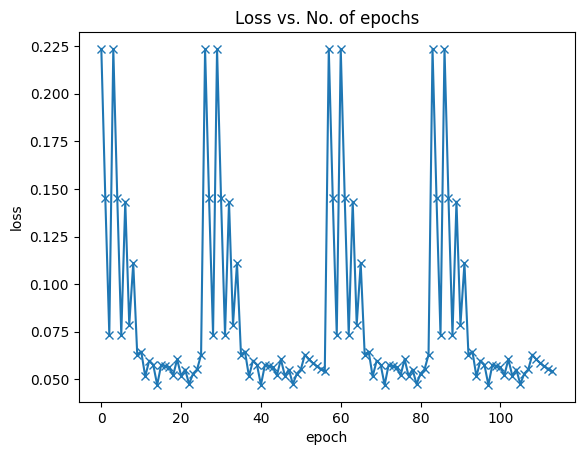

In [343]:
losses = [x[0] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

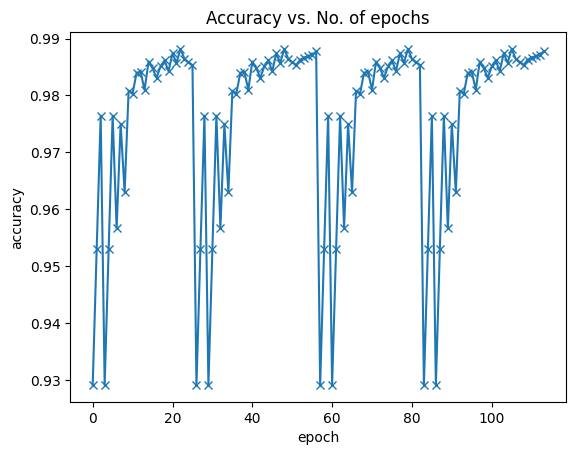

In [344]:
accuracies = [x[1] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

<h1> Predictions over the same Dataset </h1>

In [260]:
# Function to predict a given image array..

def predict_image(img, model):

    # for pixel_index in range(len(img)):
    #   img[pixel_index] = img[pixel_index] / 255


    img = np.array(img).reshape(1,28,28)


    img = torch.tensor(img)

    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

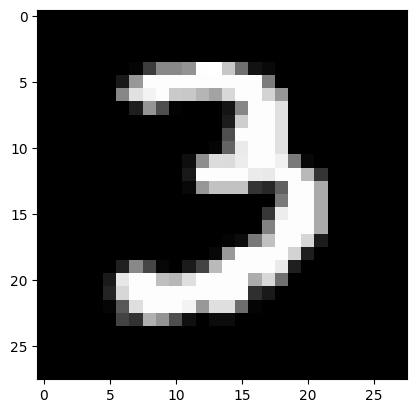

In [336]:
show_image(df['pixels'][9])

In [337]:
predict_image(df['pixels'][9], model)

3

In [338]:
# Check over whole dataset..
count = 0
for index, rows in df.iterrows():
  predict = predict_image(df['pixels'][index], model)
  label = rows['label']

  if predict == label:
    count += 1
count

<H1> Testing  Model over Test Dataset.. (For Kaggle) </H1>

In [351]:
# Load the excel file for testing..

data_file = "/content/drive/MyDrive/test.csv"
test_df = pd.read_csv(data_file)

In [355]:
# Get all the inputs for testing..

inputs = []
for index, rows in test_df.iterrows():

  input = rows.values
  inputs.append(input)

df_test = pd.DataFrame({'pixels' : inputs})
len(df_test)

28000

In [364]:
# Header of txt file..
text = "ImageId,Label\n"

# Rows ..
model.eval()
with torch.no_grad():
    for index, row in tqdm(df_test.iterrows()):

         prediction = predict_image(df_test['pixels'][index], model)
         text += f"{index+1},{prediction}\n"

28000it [00:25, 1100.85it/s]


In [366]:
with open(f'/content/drive/MyDrive/predictions.csv', 'w') as txtfile:
    txtfile.write(text)